# **1. PROBLEM STATEMENT**
---
---

### *1.1. BACKGROUND*
---

##### Debiasing the Facial Detection Systems subject to significant amounts of algorithmic bias among selected demographics. 

##### Investigating [a recently published approach](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) to addressing algorithmic bias by building a facial detection model that learns the *latent variables* underlying face image datasets and use them to adaptively re-sample the training data, thus mitigating any biases that may be present in order to train a *debiased* model.

##### Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias. 

### Thinking about bias
What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term *latent space* to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier *biased* if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab. 


# **2. DATA COLLECTION**

---
---

### *2.1. Installing the required Packages*
---

In [ ]:
# Mounting the Google Drive to get access to the file that contains the information that is required to connect to my twitter
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SETTING KAGGLE FOLDER INSIDE MyDrive AS THE WORKING DIRECTORY TO DOWNLOAD THE DATASET
%cd /content/drive/Shareddrives/IDS_576/DeepLearning
!chmod 755 -R "/content/drive/Shareddrives/DeepLearning"

/content/drive/Shareddrives/IDS_576/DeepLearning


In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
# With eager execution enabled, TensorFlow functions execute operations immediately(as opposed to adding to a graph to be executed later in a tf. compat. v1. Session ) and return concrete values (as opposed to symbolic references to a node in a computational graph).
import IPython
import functools
from tqdm import tqdm
import pdb

import pandas as pd
import numpy as np
import cv2    
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

import tensorflow as tf

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64


import time
import h5py
import sys
import glob

plt.style.use('ggplot')

%matplotlib inline

In [ ]:
tf.executing_eagerly()

True

## Exploratory Data Analysis

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
import tensorflow.python.keras.engine
#from tensorflow.python.keras.engine import get_source_inputs
from keras import backend as K
K.set_image_data_format('channels_first')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
#from tensorflow.keras.layers import BatchNormalization
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import h5py
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
attributes_df = pd.read_csv("/content/drive/Shareddrives/DataSet/list_attr_celeba.csv").replace([-1], 0)
bboxes_df = pd.read_csv("/content/drive/Shareddrives/DataSet/list_bbox_celeba.csv")
landmarks_df = pd.read_csv("/content/drive/Shareddrives/DataSet/list_landmarks_align_celeba.csv")
eval_df = pd.read_csv("/content/drive/Shareddrives/DataSet/list_eval_partition.csv")

In [ ]:
images_folder = "/content/drive/Shareddrives/DataSet/img_align_celeba/img_align_celeba/"
source_image = images_folder+"000001.jpg"


In [ ]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
import os
import shutil
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.optimizers import SGD

plt.style.use('ggplot')

%matplotlib inline

In [ ]:
attributes_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
print(*attributes_df.keys().tolist(), sep = '\n')

image_id
5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Smiling
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


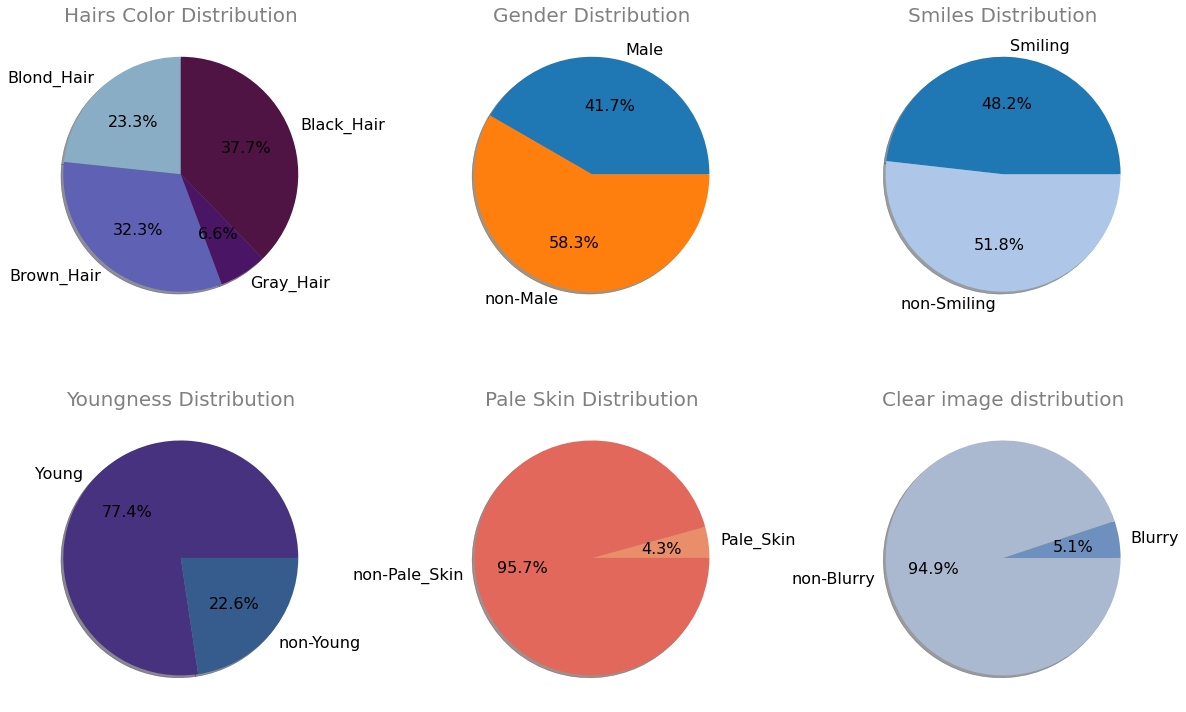

In [ ]:
## defining function to visualize each category of features
def show_pies(df = attributes_df):
        
    
    def show_categorical_dist(labels, 
                              coords,
                              title = None, 
                              colormap = 'rocket', 
                              title_params = dict(
                                  fontsize = 20, 
                                  fontweight = 20, 
                                  color = 'gray'),
                              textprops = dict(fontsize = 16)
                             ):
        
        nums = [df[label].sum() for label in labels]
        colors = sns.color_palette(colormap) 
        
        plt.subplot(*coords)
        plt.title(title, fontdict = title_params)
        plt.pie(
            nums, 
            labels=labels, 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90, 
            textprops=textprops,
            colors = colors
        )

        
    def show_binary_dist(label, 
                          coords,
                          title = None, 
                          colormap = 'rocket', 
                          title_params = dict(
                              fontsize = 20, 
                              fontweight = 20, 
                              color = 'gray'),
                          textprops = dict(fontsize = 16)
                         ):
        
        positive = df[label].sum()
        negative = len(df) - positive
        labels = [label, f'non-{label}']
        nums = [positive, negative]
        colors = sns.color_palette(colormap)
        
        plt.subplot(*coords)
        plt.title(title, fontdict = title_params)
        plt.pie(
            nums, 
            labels=labels, 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=0, 
            textprops=textprops,
            colors = colors
        )
        
    plt.figure(figsize = (20, 20))
    plt.subplots_adjust(  
        wspace = 0.4,   
        hspace = 0.2,
    )
    show_categorical_dist(
        coords = (3, 3, 1),
        labels = ['Blond_Hair', 'Brown_Hair', 'Gray_Hair', 'Black_Hair'], 
        title = 'Hairs Color Distribution',
        colormap = 'twilight'
    )
    
  
    
    show_binary_dist(
        coords = (3, 3, 2),
        label = 'Male', 
        title = 'Gender Distribution',
        colormap = 'tab10'
    )
    
    show_binary_dist(
        coords = (3, 3, 3),
        label = 'Smiling', 
        title = 'Smiles Distribution',
        colormap = 'tab20'
    )
    
    show_binary_dist(
        coords = (3, 3, 4),
        label = 'Young', 
        title = 'Youngness Distribution',
        colormap = 'viridis'
    )
    
  
    
    show_binary_dist(
        coords = (3, 3, 5),
        label = 'Pale_Skin', 
        title = 'Pale Skin Distribution',
        colormap = 'flare'
    )

    show_binary_dist(
        coords = (3, 3, 6),
        label = 'Blurry', 
        title = 'Clear image distribution',
        colormap = 'vlag'
    )
    
    plt.show()
show_pies()

In [ ]:

df_ip = pd.core.frame.DataFrame({'count' : attributes_df.groupby( ['Pale_Skin','Male'] ).size()}).reset_index()
print(df_ip)
df_ip.columns

   Pale_Skin  Male   count
0          0     0  111520
1          0     1   82378
2          1     0    6645
3          1     1    2056


Index(['Pale_Skin', 'Male', 'count'], dtype='object')

In [ ]:
df_ip['Gender']= np.where(df_ip['Male'] == 0, 'Female','Male')
df_ip= df_ip[['Pale_Skin', 'Gender', 'count']]


In [ ]:
df_ips = df_ip.rename(columns= {"count" : "Count"})
df_ips

,Pale_Skin,Gender,Count
0,0,Female,111520
1,0,Male,82378
2,1,Female,6645
3,1,Male,2056


Pale skin gender distribution


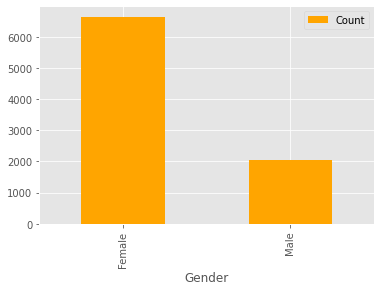

In [ ]:
## let's see the distribution od gender across pale and non-pale skin

print("Pale skin gender distribution")
df_ips[df_ips['Pale_Skin']== 1].plot(x="Gender", y=["Count"], kind="bar", color= 'orange')



Non-Pale skin gender distribution


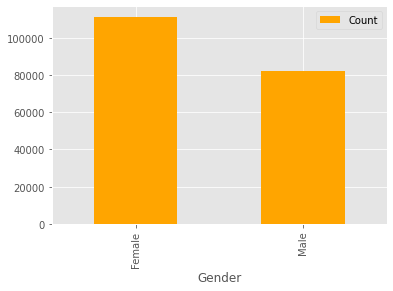

In [ ]:
print("Non-Pale skin gender distribution")
df_ips[df_ips['Pale_Skin']== 0].plot(x="Gender", y=["Count"], kind="bar", color= 'orange')


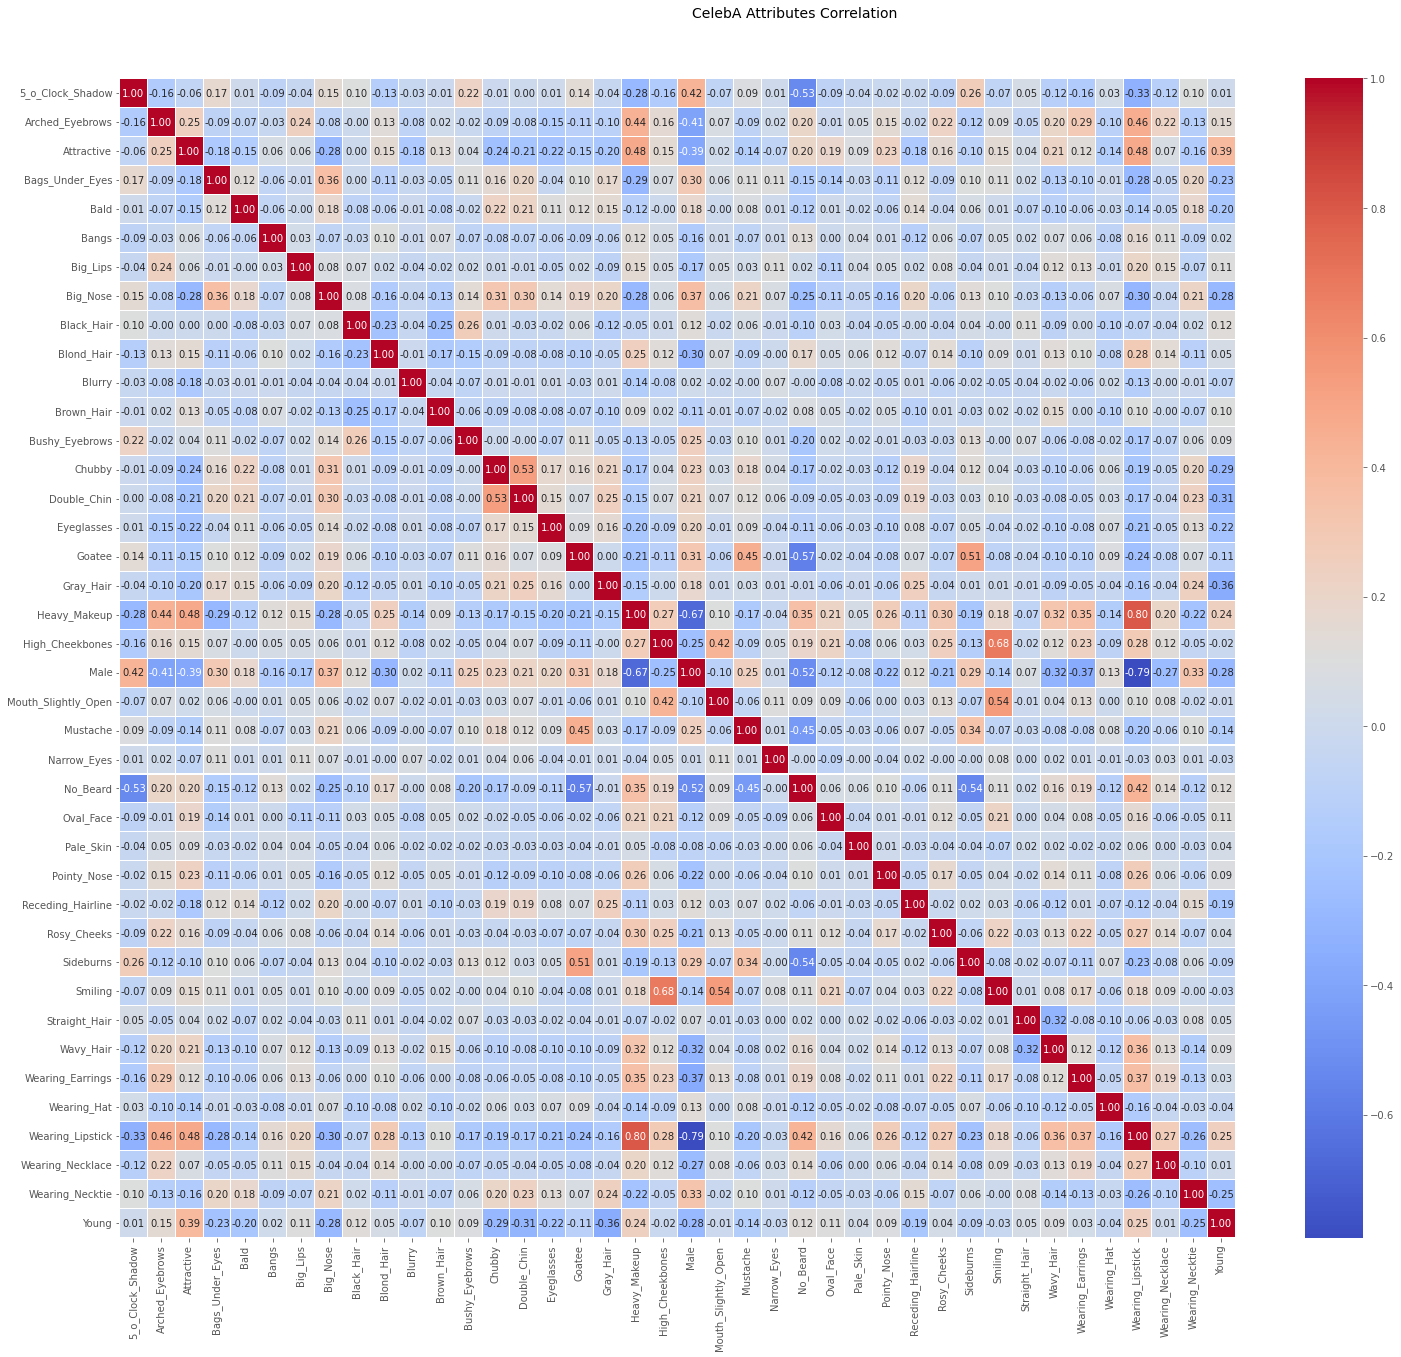

In [ ]:
f, ax = plt.subplots(figsize=(25, 20))
corr = attributes_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('CelebA Attributes Correlation', fontsize=14)

In [ ]:
bboxes_df.head()

/content/drive/Shareddrives/IDS_576/DataSet/img_align_celeba/img_align_celeba/


In [ ]:
def process_df(df, step = 50):
    new_df = pd.DataFrame(dict(x = [], y = [], kind = []))
    current_kinds = [item[:-2] for item in df.columns[1:]]
    kinds = []
    for kind in current_kinds:
        if not kind in kinds:
            kinds.append(kind)
            
    for index in range(0, len(df), step):
        current_landmarks = df.iloc[index].tolist()[1:]
        xs = current_landmarks[::2]
        ys = current_landmarks[1:][::2]
        for x, y, kind in list(zip(xs, ys, kinds)):
            new_df = new_df.append(dict(x=x, y=y, kind = kind), ignore_index=True)

    return new_df

new_landmarks_df = process_df(landmarks_df)
new_landmarks_df.head(10)

,x,y,kind
0,69.0,109.0,lefteye
1,106.0,113.0,righteye
2,77.0,142.0,nose
3,73.0,152.0,leftmouth
4,108.0,154.0,rightmouth
5,67.0,113.0,lefteye
6,110.0,112.0,righteye
7,83.0,140.0,nose
8,69.0,148.0,leftmouth
9,107.0,152.0,rightmouth


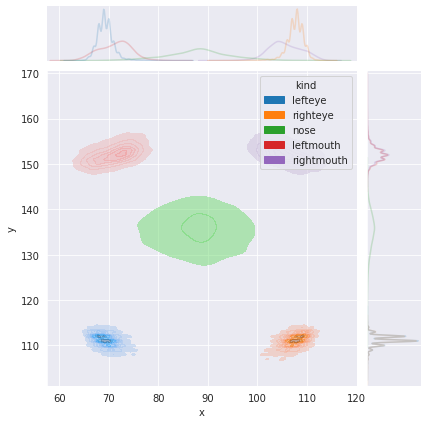

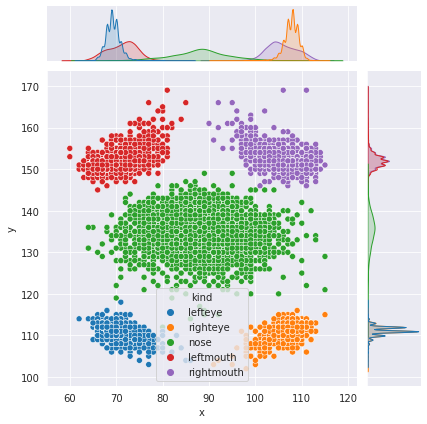

In [ ]:
### visualizing the landamrks to see which of the landmarks are present most in the pictures.
def show_landmarks_distribution(df):
    sns.set_style("darkgrid")
    
    sns.jointplot(
            data=df, 
            x="x", 
            y="y", 
            hue="kind",
            kind="kde", 
            marginal_kws={"color":"r", "alpha":.2}, 
            shade=True, 
            alpha=.5,
        )

    sns.jointplot(
            data=df, 
            x="x", 
            y="y", 
            hue="kind" ,
            marginal_kws={"color":"r", "alpha":.2}, 
        )
    
show_landmarks_distribution(new_landmarks_df)

In [ ]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


In [ ]:
pd.__version__

'1.3.5'

In [ ]:
df_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
df_attr = df_attr[['Smiling','Male','Young']]
df_attr.head()

,Smiling,Male,Young
image_id,,,
000001.jpg,1,0,1
000002.jpg,1,0,1
000003.jpg,0,1,1
000004.jpg,0,0,1
000005.jpg,0,0,1


In [ ]:
df_attr.dtypes

Smiling    int64
Male       int64
Young      int64
dtype: object

array('000001.jpg', dtype='<U10')

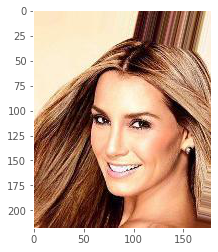

In [ ]:
# plot picture and attributes
img = load_img(path)
plt.imshow(img)
plt.grid(False)
x = np.array(path.split('/')[-1])
x

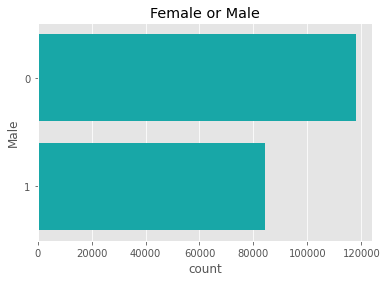

In [ ]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [ ]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [ ]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr, how='inner')
df_par_attr.head()

,partition,Smiling,Male,Young
image_id,,,,
000001.jpg,0,1,0,1
000002.jpg,0,1,0,1
000003.jpg,0,0,1,1
000004.jpg,0,0,0,1
000005.jpg,0,0,0,1


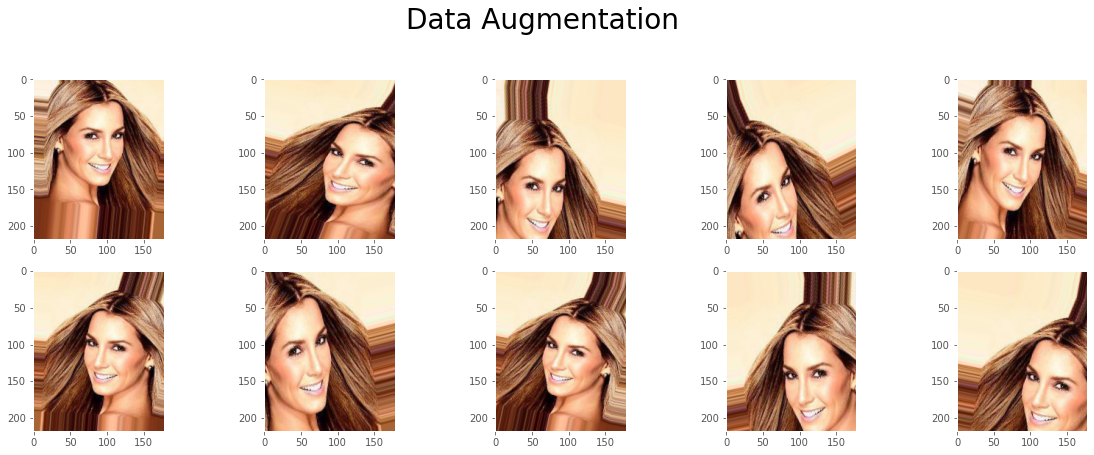

In [ ]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(path)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [ ]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

In [ ]:
def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_, df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [ ]:
# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [ ]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils

In [ ]:
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))

2022-11-30 21:26:11.119501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 21:26:11.120515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 21:26:11.472770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 21:26:11.473648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 21:26:11.474437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 0s 0us/step
number of layers: 311


In [ ]:
inc_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 108, 88, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 108, 88, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 108, 88, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer='Adam'
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
# train the model

checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', verbose=1, save_best_only=True)

In [ ]:
NUM_EPOCHS = 20

In [ ]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-30 21:26:19.303849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-30 21:26:27.075531: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 135s 185ms/step - loss: 0.7082 - accuracy: 0.5110 - val_loss: 0.6988 - val_accuracy: 0.4780

Epoch 00001: val_loss improved from inf to 0.69883, saving model to weights.best.inc.male.hdf5
Epoch 2/20
625/625 [==============================] - 112s 179ms/step - loss: 0.6910 - accuracy: 0.5392 - val_loss: 0.7075 - val_accuracy: 0.4990

Epoch 00002: val_loss did not improve from 0.69883
Epoch 3/20
625/625 [==============================] - 110s 176ms/step - loss: 0.6402 - accuracy: 0.6385 - val_loss: 92.2506 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.69883
Epoch 4/20
625/625 [==============================] - 111s 178ms/step - loss: 0.5070 - accuracy: 0.7552 - val_loss: 0.7700 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.69883
Epoch 5/20
625/625 [==============================] - 110s 176ms/step - loss: 0.3958 - accuracy: 0.8292 - val_loss: 0.9151 - val_accuracy: 0.5000

Epoch 00005: val_loss did n

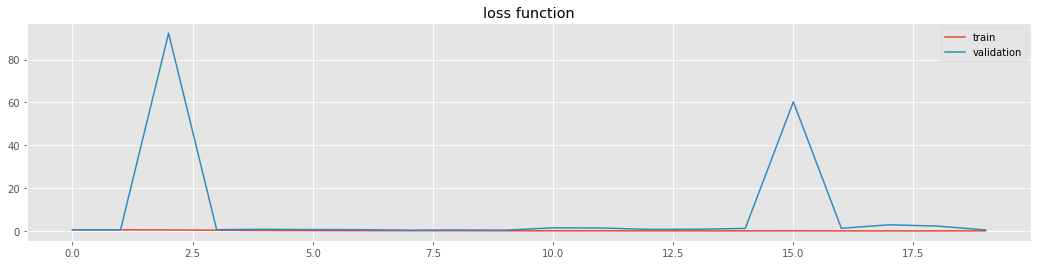

In [ ]:
# plot loss with epochs

plt.figure(figsize=(18,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()


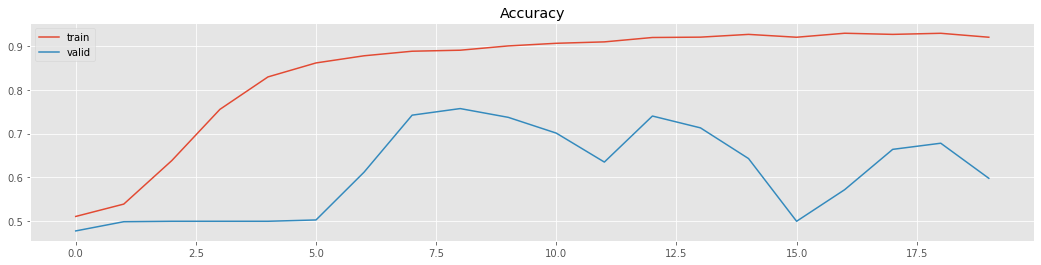

In [ ]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [ ]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 73.0000%
f1_score: 0.7648083623693379


In [ ]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()
    


In [ ]:
def gender_prediction(filename):
    '''
    predict the gender
    
    input:
        filename: str of the file name
        
    return:
        array of the prob of the targets.
    
    '''
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
     
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

In [ ]:
def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"
        
    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'
        
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )
    display(HTML(display_html))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()



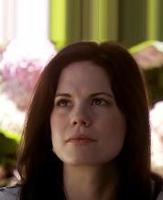


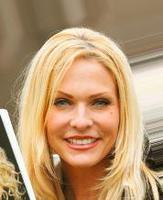


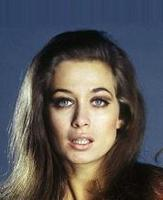


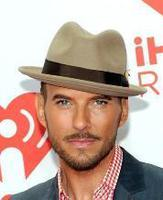


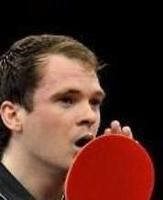

In [ ]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(5)


for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)
    
#display result
    display_result(images_folder + index, result[0], target['Male'])


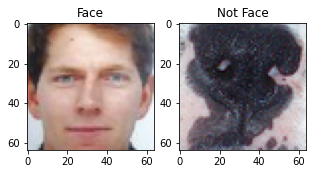

In [ ]:
### Examining the CelebA training dataset ###

# @title Change the sliders to look at positive and negative training examples! { run: "auto" }
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 24 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 20 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

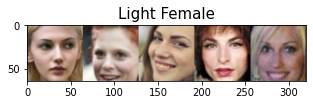

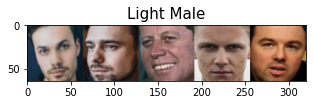

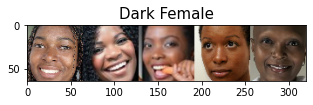

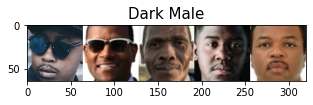

In [ ]:
### Load test dataset and plot examples ###

test_faces = get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

### *2.3. Importing the Required Modules*
---

In [ ]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
import seaborn as sns
import pandas as pd
import numpy as np
import torch 
import cv2
import os
import copy
from PIL import Image

### *2.4. Importing the Required Datsets*
---

1. Positive Training DataSet  
  * [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
  * A large-scale (over 200K images) of celebrity faces.

   
2. Negative Training DataSet  
  * [ImageNet](http://www.image-net.org/)
  * Many images across a variety of non-human categories. 


3. Test DataSet of Face Images 

  * Should use equal representation across the demographics or features of interest (skin tone and gender) due to the concern related to the potential **bias** of the learned models against certain demographics

In [ ]:
!pip install utils
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import numpy as np

from IPython import display as ipythondisplay
from string import Formatter

In [ ]:
def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')

def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()


class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [ ]:
IM_SHAPE = (64, 64, 3)

def plot_image_prediction(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(np.squeeze(img), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_prediction(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


class TrainingDatasetLoader(object):
    def __init__(self, data_path):

        print ("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, 'r')

        print ("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache['images'][:]
        self.labels = self.cache['labels'][:].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces:
            selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else:
            selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
            selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
            selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds,:,:,::-1]/255.).astype(np.float32)
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return (self.images[most_prob_inds,...]/255.).astype(np.float32)

    def get_all_train_faces(self):
        return self.images[ self.pos_train_inds ]


def get_test_faces(path):
    global files,__file__
    global cwd
    cwd = os.path.dirname(__file__)
    print(cwd)
    images = {
        "LF": [],
        "LM": [],
        "DF": [],
        "DM": []
    }
    for key in images.keys():
        files = glob.glob(os.path.join(cwd, "data", "faces", key, "*.png"))
        for file in sorted(files):
            image = cv2.resize(cv2.imread(file), (64,64))[:,:,::-1]/255.
            images[key].append(image)

    return images["LF"], images["LM"], images["DF"], images["DM"]

In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = TrainingDatasetLoader(path_to_training_data)

Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

path = images_folder + '000001.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 1000
TEST_SAMPLES = 1000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16


In [ ]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

# **3. Applying Models**

---
---

### *3.1. CNN Model for Facial Detection*
---

##### The CNN model architecture consists of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 
---

##### **Batch Normalization**
Technique for training very deep neural networks that normalizes the contributions to a layer for every 
mini-batch.
  * This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train deep neural networks.
---



### *3.2. Define the CNN model*
---

In [ ]:
n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

### *3.3. Train the standard CNN on the CelebA and ImageNet DataSets*
---

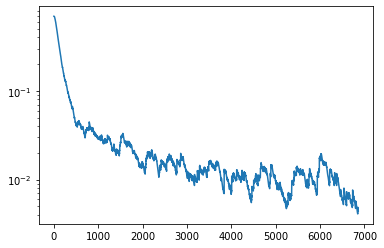

100%|██████████| 3434/3434 [04:45<00:00, 12.02it/s]


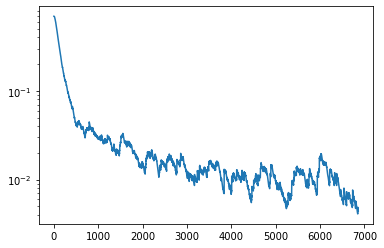

In [ ]:
# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### *3.4. Evaluate classification performance of our CelebA-trained standard CNN on the training dataset - Accuracy*
---

In [ ]:
# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 4s 22ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9974


### *3.5. Probability Evaluation of the above face demographics classified using standard CNN on the test data*
---

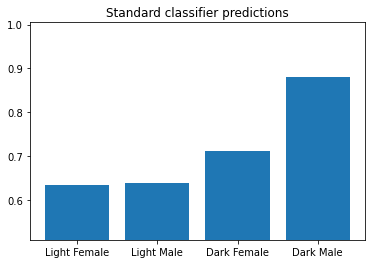

In [ ]:
standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

Model ---> BIASED 

The biasness can be because of historical bias, proxy variables, unbalanced datasets, algorithm choices and user interaction.

# **3. Mitigating ---> ALGORITHMIC BIAS**

---
---

###Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

How could we overcome this? A naive solution -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then manually even out the data with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different features that are imbalanced within the training data.

Instead, let's actually **learn** these features in an unbiased, unsupervised manner, without the need for any annotation, and then train a classifier fairly with respect to these features. In the rest of this lab, we'll do exactly that.

## 2.4 Variational autoencoder (VAE) for learning latent structure

As you saw, the accuracy of the CNN varies across the four demographics we looked at. To think about why this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem. 

Our goal is to train a *debiased* version of this classifier -- one that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that **learns a representation of the underlying latent space** to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently* during training. The key design requirement for our model is that it can learn an *encoding* of the latent features in the face data in an entirely *unsupervised* way. To achieve this, we'll turn to variational autoencoders (VAEs).

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic above and in Lecture 4, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.


### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  #latent_loss = # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  #vae_loss = # TODO
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  
  return vae_loss

Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to train a *debiased* facial classifier.

### Understanding VAEs: reparameterization 

As you may recall from lecture, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim \mathcal{N}(0,(I))$ we have: 

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

## 2.5 Debiasing variational autoencoder (DB-VAE)

Now, we'll use the general idea behind the VAE architecture to build a model, termed a [*debiasing variational autoencoder*](https://lmrt.mit.edu/sites/default/files/AIES-19_paper_220.pdf) or DB-VAE, to mitigate (potentially) unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.    

### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data). 

A general schematic of the DB-VAE approach is shown here:

![DB-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab2/img/DB-VAE.png)

Recall that we want to apply our DB-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our DB-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, **and** outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the DB-VAE loss function

This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable $\mathcal{I}_f$which reflects which training data are images of faces ($\mathcal{I}_f(y) = 1$ ) and which are images of non-faces ($\mathcal{I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + \mathcal{I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the DB-VAE loss function:



In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )

  return total_loss, classification_loss

### DB-VAE architecture

Now we're ready to define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the DB-VAE. Note that at this point, there is nothing special about how we put the model together that makes it a "debiasing" model -- that will come when we define the training operation. Here, we will define the core VAE architecture by sublassing the `Model` class; defining encoding, reparameterization, and decoding operations; and calling the network end-to-end.

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)

    # TODO: reconstruction
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

As stated, the encoder architecture is identical to the CNN from earlier in this lab. Note the outputs of our constructed DB_VAE model in the `call` function: `y_logit, z_mean, z_logsigma, z`. Think carefully about why each of these are outputted and their significance to the problem at hand.



### Adaptive resampling for automated debiasing with DB-VAE

So, how can we actually use DB-VAE to train a debiased facial detection classifier?

Recall the DB-VAE architecture: as input images are fed through the network, the encoder learns an estimate $\mathcal{Q}(z|X)$ of the latent space. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can approximate $\mathcal{Q}(z|X)$ using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint $x$ based on this approximation. These probability distributions will be used during training to re-sample the data.

You'll write a function to execute this update of the sampling probabilities, and then call this function within the DB-VAE training loop to actually debias the model. 

First, we've defined a short helper function `get_latent_mu` that returns the latent variable means returned by the encoder after a batch of images is inputted to the network:

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

Now, let's define the actual resampling algorithm `get_training_sample_probabilities`. Importantly note the argument `smoothing_fac`. This parameter tunes the degree of debiasing: for `smoothing_fac=0`, the re-sampled training set will tend towards falling uniformly over the latent space, i.e., the most extreme debiasing.

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to *faces*, not the set of negative examples. Complete the code block below to execute the training loop!

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

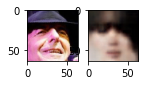

 14%|█▍        | 497/3434 [00:05<00:30, 96.98it/s]

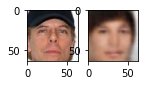

 29%|██▉       | 991/3434 [00:10<00:23, 104.76it/s]

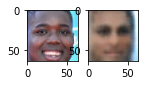

 43%|████▎     | 1492/3434 [00:15<00:19, 99.26it/s]

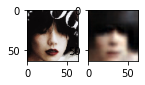

 58%|█████▊    | 1993/3434 [00:20<00:14, 100.80it/s]

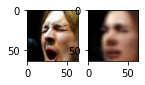

 73%|███████▎  | 2494/3434 [00:25<00:09, 99.82it/s]

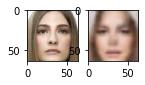

 87%|████████▋ | 2990/3434 [00:30<00:04, 106.09it/s]

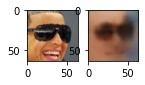

100%|██████████| 3434/3434 [00:35<00:00, 97.03it/s]


In [ ]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables) # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      plot_sample(x, y, dbvae)

Wonderful! Now we should have a trained and (hopefully!) debiased facial classification model, ready for evaluation!

## 2.6 Evaluation of DB-VAE on test dataset

Finally let's test our DB-VAE model on the test dataset, looking specifically at its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics. We will compare the performance of this debiased model against the (potentially biased) standard CNN from earlier in the lab.

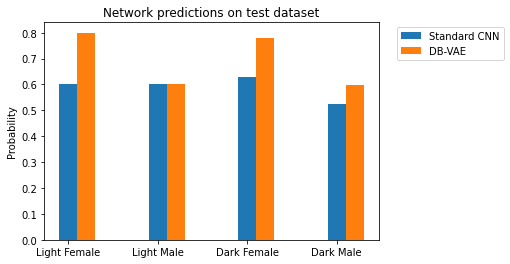

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


## 2.7 Conclusion and submission information

We encourage you to think about and maybe even address some questions raised by the approach and results outlined here:

*  How does the accuracy of the DB-VAE across the four demographics compare to that of the standard CNN? Do you find this result surprising in any way?
*  How can the performance of the DB-VAE classifier be improved even further? We purposely did not optimize hyperparameters to leave this up to you!
*  In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model? 
* Do you think it should be necessary for companies to demonstrate that their models, particularly in the context of tasks like facial detection, are not biased? If so, do you have thoughts on how this could be standardized and implemented?
* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?


<img src="https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif" />